# Entrenamiento de detección de objetos con dataset propio
En este notebook entrenaremos una arquitectura Yolo-v4 para detectar objetos de un dataset propio. Usaremos transfer learning y fine-tuning para hacer que un modelo pre-entrenado con COCO dataset aprenda los nuevos objetos del dataset propio.

Por favor seguir las instrucciones a continuación

# Configuración de Yolo-v4
Clonamos el repositorio con el código fuente.

In [3]:
!git clone https://github.com/ivansipiran/pytorch-YOLOv4.git

import sys
print("Versión de Python:", sys.version)


Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 414 (delta 3), reused 6 (delta 1), pack-reused 401
Receiving objects: 100% (414/414), 937.50 KiB | 30.24 MiB/s, done.
Resolving deltas: 100% (230/230), done.
Versión de Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]


Instalamos los requerimientos necesarios para que funcione el código fuente.

In [4]:
%cd /content/pytorch-YOLOv4
!pip install opencv_python
!pip install tensorboardX




/content/pytorch-YOLOv4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.7 MB/s eta 0:00:00


Descargamos los pesos del detector pre-entrenado. El modelo ya se encuentra almacenado en formato de Pytorch.

In [5]:
%cd /content/pytorch-YOLOv4
!gdown https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA

/content/pytorch-YOLOv4
Downloading...
From (original): https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA
From (redirected): https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA&confirm=t&uuid=5dc0337d-78cc-4da9-b40d-d6a76d2aaea2
To: /content/pytorch-YOLOv4/yolov4.conv.137.pth
100% 170M/170M [00:09<00:00, 17.5MB/s]


#Dataset

Descargar el dataset para el entrenamiento. Este dataset contiene piezas de ajedrez que queremos aprender a detectar. El modelo pre-entrenado no tuvo a este tipo de objetos en los datos del pre-entrenamiento, así que la idea es aprender estos nuevos objetos.

In [6]:
!wget http://www.ivan-sipiran.com/downloads/datasetchess.zip
!unzip datasetchess.zip

--2024-07-18 12:50:02--  http://www.ivan-sipiran.com/downloads/datasetchess.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7210448 (6.9M) [application/zip]
Saving to: ‘datasetchess.zip’

datasetchess.zip    100%[===================>]   6.88M  3.38MB/s    in 2.0s    

2024-07-18 12:50:05 (3.38 MB/s) - ‘datasetchess.zip’ saved [7210448/7210448]

Archive:  datasetchess.zip
 extracting: test/ba6289667457a113c1a753a87c041c51_jpg.rf.31874cd941dfda8ac86b77fdc97f4931.jpg  
 extracting: test/e4583d082076b2b549b3736ad1b193c9_jpg.rf.55af0c9be903e4dda4a002af87bdeaac.jpg  
 extracting: test/fdcd6ada676799da8a870f58fdf548db_jpg.rf.bdda51ee840f036af9280598f08b1879.jpg  
 extracting: test/7a34d8620235048917b28bcfd3b5572b_jpg.rf.182f59c512dcb99ed53da97dfe2d3d85.jpg  
 extracting: test/e0d38d159ad3a801d0304d7e275812cc_jpg.rf.0cd06a940c

Miremos algunos ejemplos de los datos. Hay tres folders (train, test, valid) con imágenes. Cada folder contiene un archivo con las anotaciones de los objetos a detectar. En este código, mostramos una imagen y sus anotaciones.

Número de clases:12
(1.0, 0.4980392156862745, 0.054901960784313725)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


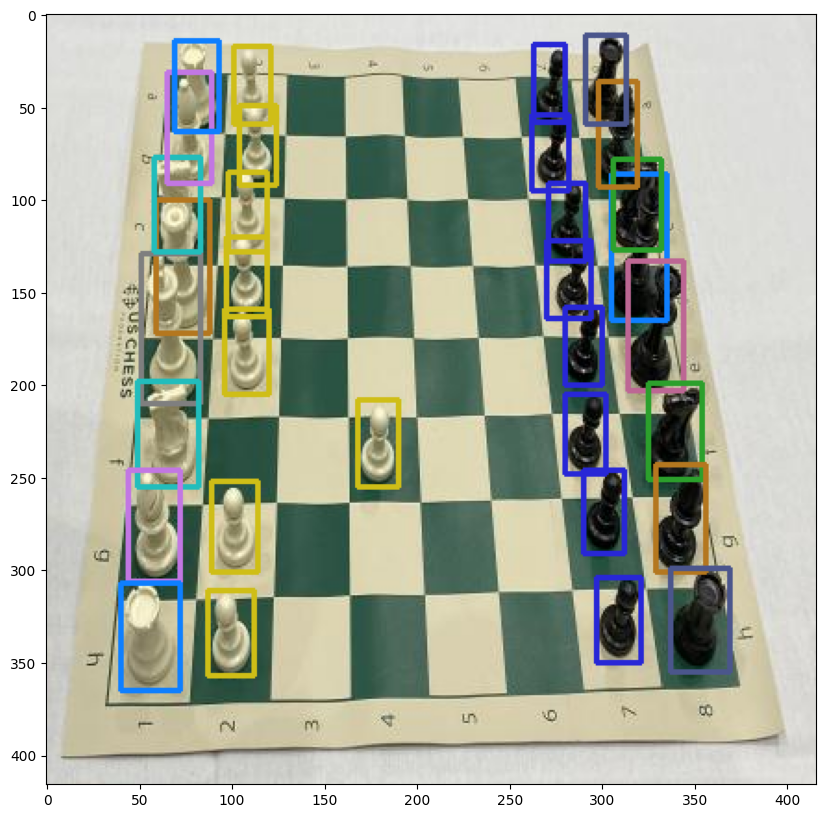

In [7]:
#Chequearemos algunos datos del ground-truth
import random
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

folder = 'train'

#Leemos el archivo de anotaciones
lineList = []
with open(folder + '/_annotations.txt') as f:
    line = f.readline()
    lineList.append(line.strip())
    while line:
        line = f.readline()
        if len(line)> 0:
            lineList.append(line.strip())

#Leer las clases dentro del folder
classList = []
with open(folder + '/_classes.txt') as f:
    line = f.readline()
    classList.append(line.strip())
    while line:
        line = f.readline()
        if len(line)>0:
            classList.append(line.strip())

numClasses = len(classList)
print(f'Número de clases:{numClasses}')

randomTest = random.choice(lineList)
annotations = randomTest.split()

palette = sns.color_palette(None, numClasses)

img = cv2.imread(folder+'/'+annotations[0])

for i in range(1,len(annotations)):
    bboxData = annotations[i].split(',')
    color = palette[int(bboxData[4])]
    print(color)
    cv2.rectangle(img, (int(bboxData[0]), int(bboxData[1])),(int(bboxData[2]), int(bboxData[3])), (int(color[0]*255),int(color[1]*255), int(color[2]*255)), 2, 1)

plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])
plt.show()


In [8]:
#Copiar los archivos de anotaciones a los folders de Yolo

%cp train/_annotations.txt train/train.txt
%cp train/_annotations.txt train.txt
%cp valid/_annotations.txt data/val.txt
%cp valid/*.jpg train/

In [9]:
# El número de clases es el número de líneas del archivo "_classes.txt"
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_classes.txt')

In [10]:
print(num_classes)

12


# Entrenar el detector propio

In [15]:

#Entrenamiento
#-b batch size (mantener este valor bajo (2-4))
#-s número de subdivisiones en el batch, relevante en el framework darknet
#-l learning rate
#-g GPU device
#pretrained indicar conde se encuentran los pesos pre-entrenados
#classes - número de clases
#dir - dónde está la data de entrenamiento
#epoch - número de épocas
!python train.py -b 2 -s 1 -l 0.001 -g 0 -pretrained ./yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 50

log file path:log/log_2024-07-18_13-26-08.txt
2024-07-18 13:26:08,611 train.py[line:446] INFO: Using device cuda
2024-07-18 13:26:09,512 train.py[line:279] INFO: Starting training:
        Epochs:          50
        Batch size:      2
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   202
        Validation size: 58
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 12
        Train label path:train.txt
        Pretrained:
    
Epoch 1/50:   0%|        | 0/202 [00:00<?, ?img/s]/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/50:  19%|▏| 38/202 [00:08<00:15, 10.33img//usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the schedule

# Cargar pesos entrenados y probar el detector

Cargamos los pesos!

In [16]:
#En esta carpeta deben estar todos los checkpoints guardados durante el entrenamiento
!ls checkpoints

Yolov4_epoch10.pth  Yolov4_epoch1.pth	Yolov4_epoch29.pth  Yolov4_epoch38.pth	Yolov4_epoch47.pth
Yolov4_epoch11.pth  Yolov4_epoch20.pth	Yolov4_epoch2.pth   Yolov4_epoch39.pth	Yolov4_epoch48.pth
Yolov4_epoch12.pth  Yolov4_epoch21.pth	Yolov4_epoch30.pth  Yolov4_epoch3.pth	Yolov4_epoch49.pth
Yolov4_epoch13.pth  Yolov4_epoch22.pth	Yolov4_epoch31.pth  Yolov4_epoch40.pth	Yolov4_epoch4.pth
Yolov4_epoch14.pth  Yolov4_epoch23.pth	Yolov4_epoch32.pth  Yolov4_epoch41.pth	Yolov4_epoch50.pth
Yolov4_epoch15.pth  Yolov4_epoch24.pth	Yolov4_epoch33.pth  Yolov4_epoch42.pth	Yolov4_epoch5.pth
Yolov4_epoch16.pth  Yolov4_epoch25.pth	Yolov4_epoch34.pth  Yolov4_epoch43.pth	Yolov4_epoch6.pth
Yolov4_epoch17.pth  Yolov4_epoch26.pth	Yolov4_epoch35.pth  Yolov4_epoch44.pth	Yolov4_epoch7.pth
Yolov4_epoch18.pth  Yolov4_epoch27.pth	Yolov4_epoch36.pth  Yolov4_epoch45.pth	Yolov4_epoch8.pth
Yolov4_epoch19.pth  Yolov4_epoch28.pth	Yolov4_epoch37.pth  Yolov4_epoch46.pth	Yolov4_epoch9.pth


In [17]:
#Escoger una imagen aleatoria
import os
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

In [18]:
%%time
##Usar el checkpoint que deseas para probar la inferencia
!python models.py {num_classes} checkpoints/Yolov4_epoch46.pth {img_path} test/_classes.txt

/content/pytorch-YOLOv4/tool/utils.py:403: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
white-bishop: 0.999999
save plot results to predictions.jpg
CPU times: user 19.8 ms, sys: 5.17 ms, total: 25 ms
Wall time: 3.51 s


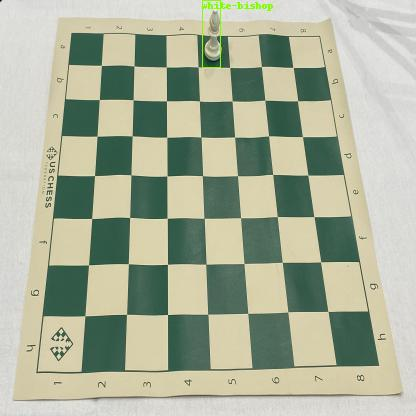

In [19]:
#Después de la inferencia, el resultado se encuentra en la imagen "predictions.jpg"
#Visualizar la inferencia
from IPython.display import Image
Image('predictions.jpg')

# Ejercicio

Usar el dataset de detección de mascarillas: [www.ivan-sipiran.com/downloads/maskwearing6.zip](www.ivan-sipiran.com/downloads/maskwearing6.zip). Intenta diferentes parámetros, este dataset es más difícil.

También podrías anotar tu propio dataset usando herramientas como: [LabelImg](https://github.com/tzutalin/labelImg), o [VoTT](https://github.com/microsoft/VoTT). Probablmente necesites cambiar el formato de los datos dependiendo del modelo que quieras entrenar.